Welcome. This is a chill notebook for using BKA. We'll help you FM your companion and run an MCMC to fit the cleanest FM we can manage. Let's get to it.

First we need to make a forward model and KLIP our data. The script below will guide you through this process

In [1]:
# if you need to use a gaussian to feed the FM in place of a ghost, run this script
%run gaussian.py 31 4

In [ ]:
# this will run a script to construct the FM
%run BKA_FM.py

Next, we'll run the MCMC to fit the FM to our KLIPed data

In [2]:
# we need to import some packages for this step
import os
import time
import pickle
import numpy as np
import astropy.io.fits as fits
import pyklip.fitpsf as fitpsf
import matplotlib.pylab as plt
import pyklip.instruments.MagAO as MagAO

You'll need to edit the variables in the cell below

In [9]:
# Your variables here
# some basics to point towards your model
outputdir = 'output' # same as you gave to the script above
prefix = 'gaussTest2' # same as you gave above here too
sep = 10 # only needs a guess
pa = 110 # guess here too
length = 2.5 # guess here also

# set some boundaries for your MCMC
x_range = 3  # in pixels, anywhere from 1.5-5 is reasonable
y_range = 3  # same as x
flux_range = 1e2 # flux can vary by an order of magnitude
corr_len_range = 5 # between 0.3 and 30

# and finally some parameters for the MCMC run
nwalkers = 100
nburn = 1000
nsteps = 3000

These next two chunks of code will setup and run the MCMC. At the end it'll print out some details of the fit.

In [10]:
output_prefix = os.path.join(outputdir, prefix)

# get FM frame
fm_frame = fits.getdata(output_prefix + "-fmpsf-KLmodes-all.fits")[0]
fm_header = fits.getheader(output_prefix + "-fmpsf-KLmodes-all.fits")
fm_centx = fm_header['PSFCENTX']
fm_centy = fm_header['PSFCENTY']

# get data_stamp frame
data_frame = fits.getdata(output_prefix + "-klipped-KLmodes-all.fits")[0]
data_header = fits.getheader(output_prefix + "-klipped-KLmodes-all.fits")
data_centx = data_header['PSFCENTX']
data_centy = data_header['PSFCENTY']

# get initial guesses. Should be in the header but aren't?
guesssep = sep
guesspa = pa

# create FM Astrometry object - 13 is fitboxsize
fma = fitpsf.FMAstrometry(guesssep, guesspa, 13)

# generate FM stamp
# padding should be greater than 0 so we don't run into interpolation problems
fma.generate_fm_stamp(fm_frame, [fm_centx, fm_centy], padding=5)

# generate data_stamp stamp
# note that dr=4 means we are using a 4 pixel wide annulus to sample the noise for each pixel
# exclusion_radius excludes all pixels less than that distance from the estimated location of the planet
fma.generate_data_stamp(data_frame, [data_centx, data_centy], dr=4, exclusion_radius=10)

# set kernel, no read noise
corr_len_guess = length
corr_len_label = r"$l$"
fma.set_kernel("matern32", [corr_len_guess], [corr_len_label])

# set bounds based on given boundaries
fma.set_bounds(x_range, y_range, flux_range, [corr_len_range])

In [11]:
t0 = time.time()

# run MCMC fit
fma.fit_astrometry(nwalkers=nwalkers, nburn=nburn, nsteps=nsteps, numthreads=4)

t1 = time.time()
print("time taken: ", str(np.round(t1-t0)), " seconds")

fma.propogate_errs(star_center_err=0.1, platescale=MagAO.MagAOData.lenslet_scale*1000, platescale_err=0.000015, pa_offset=-0.59, pa_uncertainty=0.3)


# show what the raw uncertainites are on the location of the planet
print("\nPlanet Raw RA offset is {0} +/- {1}, Raw Dec offset is {2} +/- {3}".format(fma.raw_RA_offset.bestfit, fma.raw_RA_offset.error,
                                                                                    fma.raw_Dec_offset.bestfit, fma.raw_Dec_offset.error))

# Full error budget included
print("Planet RA offset is at {0} with a 1-sigma uncertainity of {1}".format(fma.RA_offset.bestfit, fma.RA_offset.error))
print("Planet Dec offset is at {0} with a 1-sigma uncertainity of {1}".format(fma.Dec_offset.bestfit, fma.Dec_offset.error))

# Propogate errors into separation and PA space
print("Planet separation is at {0} with a 1-sigma uncertainity of {1}".format(fma.sep.bestfit, fma.sep.error))
print("Planet PA at {0} with a 1-sigma uncertainity of {1}".format(fma.PA.bestfit, fma.PA.error))

print("Flux is {0} with a 1-sigma uncertainty of {1}" .format(fma.raw_flux.bestfit, fma.raw_flux.error))

Running burn in
Burn in finished. Now sampling posterior
MCMC sampler has finished
time taken:  302.0  seconds
Raw X/Y Centroid = (7.3930183441269435, -2.838485942035959) with statistical error of [-0.13190073  0.12684296] pix in X and [-0.08868966  0.08908844] pix in Y
Raw Sep/PA Centroid = (7.920352849630119, 111.00381629838442) with statistical error of [ 0.13162999 -0.12615203] pix in Sep and [ 0.64766892 -0.64480202] pix in PA
Adding in star center uncertainity
Converting pixels to milliarcseconds
Adding in plate scale error
Adding in a PA/North angle offset
Adding in PA uncertainity
Sep = 7.920352849630119 +/- 0.1631432262844401 ([0.16530715 0.1609793 ]) pix, PA = 110.41381629838442 +/- 1.0153462958812711 ([1.01625864 1.01443395]) degrees
Sep = 62.185066328300955 +/- 1.2808864180377326 ([1.29787606 1.26389678]) mas, PA = 110.41381629838442 +/- 1.0153462958812711 ([1.01625864 1.01443395]) degrees
RA offset = 7.421817303604094 +/- 0.16425586909448023 ([0.16630942 0.16220231]) pix
D

Now onto plotting! at the bottom of each of the next cells there is a commented savefig statement that you can uncomment when you are satisfied with how your figures look

Text(0, 0.5, '$l$')

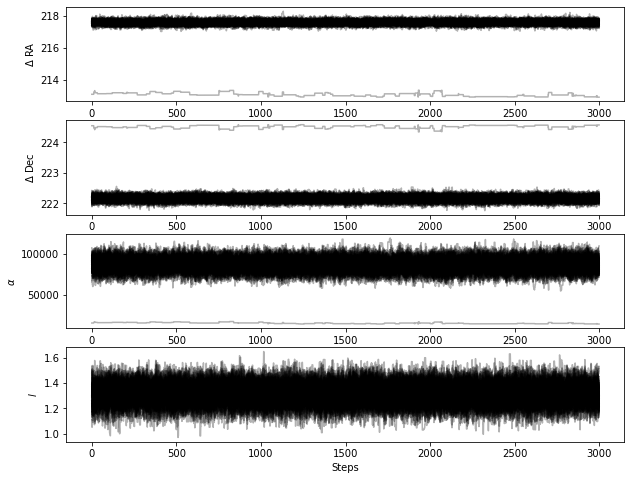

In [12]:
# We load in the results of the MCMC from the compressed pickle file
# the pyklip code has generated for us

chain_info = pickle.load(open("bka-chain.pkl", "rb"))

# First, let's plot the chains

fig=plt.figure(figsize=(10,8))
# plot RA offset
ax1 = fig.add_subplot(411)
ax1.plot(chain_info[:,:,0].T, '-', color='k', alpha=0.3)
ax1.set_xlabel("Steps")
ax1.set_ylabel(r"$\Delta$ RA")

# plot Dec offset
ax2 = fig.add_subplot(412)
ax2.plot(chain_info[:,:,1].T, '-', color='k', alpha=0.3)
ax2.set_xlabel("Steps")
ax2.set_ylabel(r"$\Delta$ Dec")

# plot flux scaling
ax3 = fig.add_subplot(413)
ax3.plot(chain_info[:,:,2].T, '-', color='k', alpha=0.3)
ax3.set_xlabel("Steps")
ax3.set_ylabel(r"$\alpha$")

# plot hyperparameters.. we only have one for this example: the correlation length
ax4 = fig.add_subplot(414)
ax4.plot(chain_info[:,:,3].T, '-', color='k', alpha=0.3)
ax4.set_xlabel("Steps")
ax4.set_ylabel(r"$l$")

#plt.savefig(outputdir+"/BKA_chain.png")

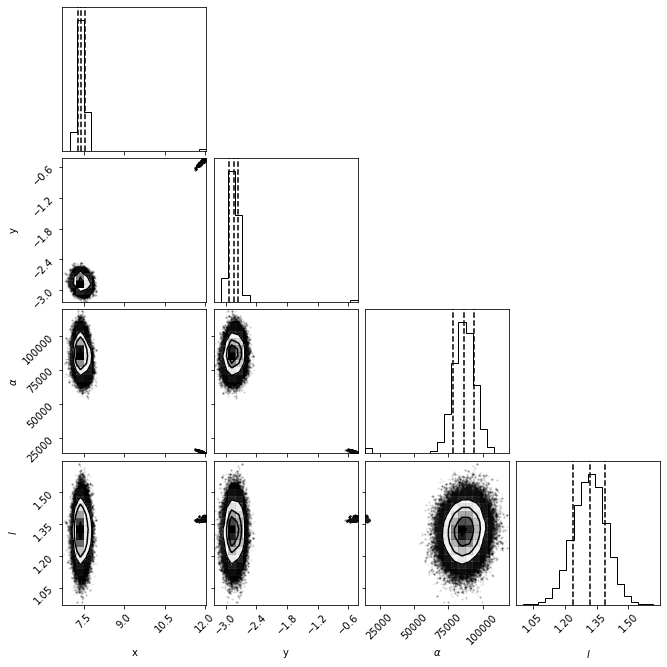

In [13]:
# the other two figures are easier to make, because there are methods
# already written

# Second is the corner plot
fig = fma.make_corner_plot()
#plt.savefig(outputdir+"/BKA_corner.png")

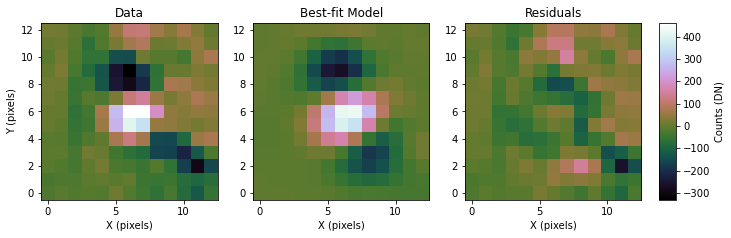

In [14]:
# And third is the model comparison and residuals
fig = fma.best_fit_and_residuals()
#plt.savefig(outputdir+"/BKA_residuals.png")

Congratulations! You've reached the written end of this notebook, but there's so much more out there. I believe in you.